In [1]:
!pip install --upgrade transformers
!pip install scipy
!pip install pycocotools -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 110.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
import os
import random
from torch.utils.data import Dataset, DataLoader   # <<< FIX HERE
from tqdm import tqdm
from torchvision.datasets import CocoDetection

In [ ]:
from huggingface_hub import login

login("YOUR_TOKEN", add_to_git_credential=False)

In [4]:
class CocoMiniDet(Dataset):
    """
    COCO-mini thật:
    - Dùng val2017 (5k ảnh), lấy num_images đầu.
    - Trả về:
        img: tensor [3,H,W] đã resize
        target: {"boxes": [N,4] (cx,cy,w,h norm), "labels":[N]}
    """
    def __init__(self, img_root, ann_file, num_images=1000, img_size=256):
        self.base = CocoDetection(img_root, ann_file)
        # mới thêm dòng này
        coco = self.base.coco
        cat_ids = sorted(coco.getCatIds())            # COCO cat ids thật
        self.cat2contig = {cid: i for i, cid in enumerate(cat_ids)}
        self.contig2cat = {i: cid for cid, i in self.cat2contig.items()}
        self.num_fg_classes = len(cat_ids)            # thường = 80

        
        self.img_size = img_size

        # lấy list id ảnh, cắt num_images đầu
        self.ids = self.base.ids[:num_images]

        # map id -> index trong base
        self.id_to_idx = {img_id: i for i, img_id in enumerate(self.base.ids)}

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor()   # -> [0,1]
        ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        base_idx = self.id_to_idx[img_id]

        img, anns = self.base[base_idx]   # img: PIL, anns: list dict

        W, H = img.size
        img = self.transform(img)         # [3,img_size,img_size]

        boxes = []
        labels = []

        for ann in anns:
            if ann.get("iscrowd", 0) == 1:
                continue
            x, y, w, h = ann["bbox"]      # COCO: x,y,w,h (pixel)
            # chuyển sang cx,cy,w,h theo TỈ LỆ (0..1)
            cx = (x + w/2) / W
            cy = (y + h/2) / H
            bw = w / W
            bh = h / H
            boxes.append([cx, cy, bw, bh])
            # labels.append(ann["category_id"])   # COCO id (1..90)
            labels.append(self.cat2contig[ann["category_id"]] + 1)  # +1 vì 0 là background


        # if len(boxes) == 0:
        #     # không có annotation → tạo dummy box cho đỡ vỡ loss
        #     boxes = [[0.5, 0.5, 0.1, 0.1]]
        #     labels = [0]   # background

        # target = {
        #     "boxes": torch.tensor(boxes, dtype=torch.float32),
        #     "labels": torch.tensor(labels, dtype=torch.long),
        # }
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),         # cxcywh norm
            "labels": torch.tensor(labels, dtype=torch.long),          # 0..K (0=bg)
            "image_id": int(img_id),                                   # ✅ COCOeval cần
            "orig_size": (int(H), int(W)),                             # ✅ COCOeval cần
        }
        return img, target


def collate_fn(batch):
    imgs = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    imgs = torch.stack(imgs, dim=0)
    return imgs, targets

In [5]:
import os
root = "/content/data/coco"
os.makedirs(root, exist_ok=True)

# --- download val2017 (NHỎ HƠN RẤT NHIỀU) ---
!wget -q http://images.cocodataset.org/zips/val2017.zip -O {root}/val2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O {root}/ann.zip

# --- unzip ---
!unzip -q {root}/val2017.zip -d {root}
!unzip -q {root}/ann.zip -d {root}

import torchvision.transforms as T

coco_root = "/content/data/coco"

# DÙNG VAL2017 (5k ảnh)
img_root  = os.path.join(coco_root, "val2017")
ann_file  = os.path.join(coco_root, "annotations", "instances_val2017.json")

num_classes = 91
img_size = 256

# lấy ít ảnh thôi, ví dụ 1000 để train thử
num_images = 3000

full_dataset = CocoMiniDet(
    img_root=img_root,
    ann_file=ann_file,
    num_images=num_images,
    img_size=img_size
)

train_size = int(num_images * 0.8)
val_size   = num_images - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,         # tăng tốc load
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Train size: 2400 Val size: 600


In [6]:
class HF_DINOv3_Backbone(nn.Module):
    """
    Backbone dùng facebook/dinov3-vits16-pretrain-lvd1689m
    - KHÔNG dùng AutoImageProcessor, tự resize + normalize.
    - BỎ CLS + REGISTER TOKENS, chỉ giữ patch tokens.
    - Trả về feature map [B, out_dim, H, W] cho DETR.
    """
    def __init__(
        self,
        model_name="facebook/dinov3-vits16-pretrain-lvd1689m",
        out_dim=256,
        resize_size=256,
    ):
        super().__init__()
        self.resize_size = resize_size

        # Load backbone từ HF
        self.model = AutoModel.from_pretrained(
            model_name,
            torch_dtype=torch.float32,
            device_map=None,
        )

        # Đọc số register tokens (DINOv3 thường = 4)
        self.num_register_tokens = getattr(self.model.config, "num_register_tokens", 0)

        # Đóng băng backbone
        for p in self.model.parameters():
            p.requires_grad = False

        self.embed_dim = self.model.config.hidden_size  # ViT-S: 384
        self.out_dim = out_dim

        # Project 384 → 256
        self.proj = nn.Conv2d(self.embed_dim, out_dim, kernel_size=1)

        # ImageNet mean/std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)

    def preprocess(self, x):
        # x: [B,3,H,W] trong [0,1]
        x = F.interpolate(
            x,
            size=(self.resize_size, self.resize_size),
            mode="bilinear",
            align_corners=False,
        )
        x = (x - self.mean) / self.std
        return x

    @torch.no_grad()
    def forward_features(self, x):
        outputs = self.model(pixel_values=x)
        tokens = outputs.last_hidden_state  # [B, 1 + reg + N, C]

        # Bỏ CLS + REGISTER TOKENS, chỉ giữ patch tokens
        # 1 CLS + num_register_tokens reg
        start = 1 + self.num_register_tokens
        tokens = tokens[:, start:, :]      # [B, N_patch, C]
        return tokens

    def forward(self, x):
        x = self.preprocess(x)
        tokens = self.forward_features(x)   # [B, N, C]

        B, N, C = tokens.shape
        H = W = int(N ** 0.5)               # bây giờ N = 16*16 = 256

        tokens = tokens.transpose(1, 2)     # [B, C, N]
        feat = tokens.reshape(B, C, H, W)   # [B, C, H, W]
        feat = self.proj(feat)              # [B, out_dim, H, W]
        return feat


In [7]:
from torch.nn import functional as F

class DETR(nn.Module):
    def __init__(self, backbone, num_classes=91, hidden_dim=256, num_queries=100):
        super().__init__()
        self.backbone = backbone

        self.input_proj = nn.Conv2d(backbone.out_dim, hidden_dim, 1)

        self.query_embed = nn.Embedding(num_queries, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=8, dim_feedforward=2048
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim, nhead=8, dim_feedforward=2048
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)

        self.class_embed = nn.Linear(hidden_dim, num_classes)
        self.bbox_embed  = nn.Linear(hidden_dim, 4)


    def forward(self, x):
        B = x.shape[0]

        feat = self.backbone(x)            # [B,C,h,w]
        feat = self.input_proj(feat)       # [B,Hdim,h,w]

        B, C, h, w = feat.shape
        src = feat.flatten(2).permute(2, 0, 1)   # [HW,B,C]
        memory = self.encoder(src)              # [HW,B,C]


        # ⭐ dùng chính query_embed làm tgt
        query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1)  # [Q,B,C]

        hs = self.decoder(tgt=query_embed, memory=memory)   # [Q,B,C]

        hs = hs.transpose(0, 1)                             # [B,Q,C]

        logits = self.class_embed(hs)           # [B,Q,num_classes]
        boxes  = self.bbox_embed(hs).sigmoid()  # [B,Q,4] (cx,cy,w,h)

        return {"pred_logits": logits, "pred_boxes": boxes}


In [8]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # ------------------------------
# # Positional Encoding kiểu DETR
# # ------------------------------
# class PositionEmbeddingSine(nn.Module):
#     def __init__(self, num_pos_feats=128, temperature=10000.0):
#         super().__init__()
#         self.num_pos_feats = num_pos_feats
#         self.temperature = temperature

#     def forward(self, x):
#         # x: [B, C, H, W]
#         B, C, H, W = x.shape
#         device = x.device

#         y_embed = torch.linspace(0, H-1, H, device=device).unsqueeze(1).repeat(1, W)
#         x_embed = torch.linspace(0, W-1, W, device=device).unsqueeze(0).repeat(H, 1)

#         dim_t = torch.arange(self.num_pos_feats, device=device, dtype=torch.float32)
#         dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

#         # sin/cos → [H,W,128]
#         pos_x = x_embed[..., None] / dim_t
#         pos_y = y_embed[..., None] / dim_t

#         pos_x = torch.stack([pos_x.sin(), pos_x.cos()], dim=-1).flatten(-2)  # [H,W,128]
#         pos_y = torch.stack([pos_y.sin(), pos_y.cos()], dim=-1).flatten(-2)  # [H,W,128]

#         # ⭐ CHỈ GHÉP 128 + 128 = 256
#         pos = torch.cat([pos_y, pos_x], dim=-1)  # [H,W,256]

#         # → [B,256,H,W]
#         pos = pos.permute(2,0,1).unsqueeze(0).repeat(B,1,1,1)
#         return pos



# # ------------------------------
# # DETR với Positional Encoding
# # ------------------------------
# class DETR(nn.Module):
#     def __init__(self, backbone, num_classes=91, hidden_dim=256, num_queries=100):
#         super().__init__()
#         self.backbone = backbone  # HF_DINOv3_Backbone

#         # project từ backbone.out_dim -> hidden_dim (256)
#         self.input_proj = nn.Conv2d(backbone.out_dim, hidden_dim, 1)

#         # positional encoding cho feature map
#         self.position_embed = PositionEmbeddingSine(num_pos_feats=hidden_dim // 4)

#         # query embedding (object queries)
#         self.query_embed = nn.Embedding(num_queries, hidden_dim)

#         # Transformer encoder/decoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=hidden_dim,
#             nhead=8,
#             dim_feedforward=2048,
#             batch_first=False,  # dùng [S, B, E]
#         )
#         self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

#         decoder_layer = nn.TransformerDecoderLayer(
#             d_model=hidden_dim,
#             nhead=8,
#             dim_feedforward=2048,
#             batch_first=False,
#         )
#         self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)

#         # heads
#         self.class_embed = nn.Linear(hidden_dim, num_classes)
#         self.bbox_embed  = nn.Linear(hidden_dim, 4)

#     def forward(self, x):
#         """
#         x: [B, 3, H, W] (0..1)
#         return:
#           {
#             "pred_logits": [B, num_queries, num_classes],
#             "pred_boxes":  [B, num_queries, 4]  (cx,cy,w,h normalized)
#           }
#         """
#         B = x.shape[0]

#         # 1) Backbone DINOv3 -> feature map [B, Cb, Hb, Wb]
#         feat = self.backbone(x)             # [B, Cb, h, w]
#         feat = self.input_proj(feat)        # [B, Hdim, h, w]

#         B, C, h, w = feat.shape

#         # 2) Positional encoding trên feature map
#         pos = self.position_embed(feat)     # [B, C, h, w]

#         # 3) Chuẩn bị cho encoder: [HW, B, C]
#         src = feat.flatten(2).permute(2, 0, 1)    # [HW, B, C]
#         pos_flat = pos.flatten(2).permute(2, 0, 1)  # [HW, B, C]

#         # 4) Encoder với pos
#         memory = self.encoder(src + pos_flat)     # [HW, B, C]

#         # 5) Chuẩn bị query cho decoder
#         #    query_embed: [num_queries, B, C]
#         query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1)
#         # Ta dùng query_embed như "content" luôn (giống bản simple bạn làm)
#         # Nếu muốn giống DETR gốc hơn:
#         #   tgt = torch.zeros_like(query_embed)
#         #   hs = self.decoder(tgt, memory)
#         # ở đây mình giữ kiểu bạn quen dùng:
#         hs = self.decoder(tgt=query_embed, memory=memory)  # [num_queries, B, C]

#         # 6) Chuyển về [B, num_queries, C]
#         hs = hs.transpose(0, 1)  # [B, num_queries, C]

#         # 7) Heads
#         logits = self.class_embed(hs)          # [B, Q, num_classes]
#         boxes  = self.bbox_embed(hs).sigmoid() # [B, Q, 4]  (cx,cy,w,h in [0,1])

#         return {"pred_logits": logits, "pred_boxes": boxes}


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

backbone = HF_DINOv3_Backbone(
    model_name="facebook/dinov3-vits16-pretrain-lvd1689m",
    out_dim=256,
)

for p in backbone.parameters():
    p.requires_grad = False

# model = DETR(backbone, num_classes=91, hidden_dim=256, num_queries=100)

# model = DETR(backbone, num_classes=train_dataset.num_fg_classes + 1, hidden_dim=256, num_queries=100)

model = DETR(
    backbone,
    num_classes=train_dataset.dataset.num_fg_classes + 1,
    hidden_dim=256,
    num_queries=100
)

model = model.to(device)
# model.eval()

print("Model ready!")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model ready!


In [11]:
from scipy.optimize import linear_sum_assignment

class HungarianMatcher(nn.Module):
    def __init__(self, cost_class=1.0, cost_bbox=5.0):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox

    @torch.no_grad()
    def forward(self, outputs, targets):
        pred_logits = outputs["pred_logits"]   # [B,Q,C]
        pred_boxes  = outputs["pred_boxes"]    # [B,Q,4]
        B, Q, C = pred_logits.shape

        out_prob = pred_logits.softmax(-1)     # [B,Q,C]
        out_bbox = pred_boxes                  # [B,Q,4]

        indices = []

        for b in range(B):
            tgt = targets[b]

            device = out_bbox.device   # <-- Quan trọng

            tgt_ids  = tgt["labels"].to(device)    # [N]
            tgt_bbox = tgt["boxes"].to(device)     # [N,4]

            N = tgt_ids.numel()
            if N == 0:
                indices.append((
                    torch.empty(0, dtype=torch.long),
                    torch.empty(0, dtype=torch.long)
                ))
                continue

            # cost class
            cost_class = -out_prob[b][:, tgt_ids]   # [Q,N]

            # cost bbox (L1)
            cost_bbox = torch.cdist(out_bbox[b], tgt_bbox, p=1)   # [Q,N]

            # total cost
            C = self.cost_class * cost_class + self.cost_bbox * cost_bbox
            C = C.cpu()  # Hungarian chạy CPU

            row_ind, col_ind = linear_sum_assignment(C)

            indices.append((
                torch.as_tensor(row_ind, dtype=torch.long, device=device),
                torch.as_tensor(col_ind, dtype=torch.long, device=device),
            ))

        return indices


In [12]:
def detr_loss(outputs, targets, matcher, num_classes=91, lambda_bbox=5.0):
    """
    Loss kiểu DETR đơn giản:
    - CE trên TẤT CẢ query (matched → class thật, unmatched → background=0)
    - L1 bbox trên các query được match với GT (Hungarian)
    """
    pred_logits = outputs["pred_logits"]   # [B,Q,C]
    pred_boxes  = outputs["pred_boxes"]    # [B,Q,4]
    B, Q, C = pred_logits.shape
    device = pred_logits.device

    # 1) Hungarian: lấy indices match cho từng ảnh trong batch
    indices = matcher(outputs, targets)

    # 2) Tạo full label cho tất cả query (mặc định background=0)
    tgt_labels_all = torch.zeros((B, Q), dtype=torch.long, device=device)

    bbox_loss = 0.0
    total_matched = 0

    for b, (src_idx, tgt_idx) in enumerate(indices):
        if src_idx.numel() == 0:
            continue

        src_idx = src_idx.to(device)
        tgt_idx = tgt_idx.to(device)

        tgt = targets[b]
        gt_labels = tgt["labels"].to(device)[tgt_idx]  # [M]
        gt_boxes  = tgt["boxes"].to(device)[tgt_idx]   # [M,4]

        # gán label cho các query được match
        tgt_labels_all[b, src_idx] = gt_labels

        # bbox loss chỉ tính trên query matched
        src_boxes = pred_boxes[b, src_idx]             # [M,4]
        bbox_loss += F.l1_loss(src_boxes, gt_boxes, reduction="sum")
        total_matched += gt_boxes.shape[0]

    # giảm trọng số cho class background = 0
    no_object_coef = 0.1
    weight = torch.ones(C, device=device)
    weight[0] = no_object_coef
    
    # 3) CE loss trên toàn bộ [B,Q]
    ce_loss = F.cross_entropy(
        pred_logits.view(-1, C),
        tgt_labels_all.view(-1),
        weight=weight,
        reduction="mean"
    )

    # Normalize bbox loss
    if total_matched == 0:
        bbox_loss = pred_boxes.sum() * 0
    else:
        bbox_loss = bbox_loss / total_matched

    loss = ce_loss + lambda_bbox * bbox_loss
    return loss, ce_loss.detach(), bbox_loss.detach()


In [13]:
import numpy as np
import torch
from pycocotools.cocoeval import COCOeval

def box_cxcywh_to_xywh(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    x = cx - 0.5 * w
    y = cy - 0.5 * h
    return torch.stack([x, y, w, h], dim=-1)

def rescale_xywh_norm_to_abs(xywh_norm, img_w, img_h):
    xywh = xywh_norm.clone()
    xywh[:, 0] *= img_w
    xywh[:, 1] *= img_h
    xywh[:, 2] *= img_w
    xywh[:, 3] *= img_h
    return xywh

@torch.no_grad()
def evaluate_map_050_095(model, data_loader, coco_gt, device, contig2cat,
                         background_id=0, score_thresh=0.05, topk=100, max_batches=None):
    model.eval()
    if hasattr(model, "backbone"):
        model.backbone.eval()

    results = []
    seen = 0

    for images, targets in data_loader:
        images = images.to(device)
        out = model(images)  # pred_logits: [B,Q,C], pred_boxes: [B,Q,4] (cxcywh norm)

        B, Q, C = out["pred_logits"].shape

        for i in range(B):
            t = targets[i]
            image_id = int(t["image_id"])
            H, W = t["orig_size"]

            logits = out["pred_logits"][i]       # [Q,C]
            boxes  = out["pred_boxes"][i]        # [Q,4]

            probs = logits.softmax(-1)           # [Q,C]
            probs[:, background_id] = 0.0        # bỏ background

            scores, labels = probs.max(-1)       # [Q]
            keep = scores >= score_thresh
            scores = scores[keep]
            labels = labels[keep]
            boxes  = boxes[keep]

            if scores.numel() == 0:
                continue

            if scores.numel() > topk:
                idx = torch.topk(scores, k=topk).indices
                scores = scores[idx]
                labels = labels[idx]
                boxes  = boxes[idx]

            xywh_norm = box_cxcywh_to_xywh(boxes).clamp(0, 1)
            xywh_abs  = rescale_xywh_norm_to_abs(xywh_norm, W, H)

            for s, l, b in zip(scores.tolist(), labels.tolist(), xywh_abs.tolist()):
                # label l đang là contiguous+1 -> map về COCO category_id thật
                coco_cat = contig2cat[int(l - 1)]  # trừ 1 để về 0..K-1
                results.append({
                    "image_id": image_id,
                    "category_id": int(coco_cat),
                    "bbox": [float(b[0]), float(b[1]), float(b[2]), float(b[3])],  # xywh abs
                    "score": float(s)
                })

        seen += 1
        if max_batches is not None and seen >= max_batches:
            break

    if len(results) == 0:
        print("Không có detection nào. Hãy thử hạ score_thresh xuống 0.01.")
        return None

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")

    # ✅ đúng câu trong report: [0.5 : 0.05 : 0.95]
    coco_eval.params.iouThrs = np.arange(0.5, 0.96, 0.05)

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # stats[0]=AP@[.5:.95], stats[1]=AP50, stats[2]=AP75...
    return coco_eval.stats


In [16]:
num_epochs = 20

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.05
)

matcher = HungarianMatcher(cost_class=1.0, cost_bbox=5.0)

for epoch in range(num_epochs):
    model.train()
    
    model.backbone.eval()
    
    total_loss = 0.0
    total_ce = 0.0
    total_bbox = 0.0
    num_batches = 0

    for imgs, targets in train_loader:
        imgs = imgs.to(device)
        # targets là list dict, đã ở CPU, matcher tự handle

        outputs = model(imgs)
        loss, ce, bbox = detr_loss(outputs, targets, matcher)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_ce   += float(ce)
        total_bbox += float(bbox)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"loss={total_loss/len(train_loader):.4f} | "
        f"ce={total_ce/len(train_loader):.4f} | "
        f"bbox={total_bbox/len(train_loader):.4f}"
    )
    # coco_gt = val_dataset.base.coco

    coco_gt = val_dataset.dataset.base.coco


    stats = evaluate_map_050_095(
        model=model,
        data_loader=val_loader,
        coco_gt=coco_gt,
        device=device,
        # contig2cat=val_dataset.contig2cat,
        contig2cat=val_dataset.dataset.contig2cat,
        background_id=0,
        score_thresh=0.05,
        topk=100,
        max_batches=20  # demo nhanh; bỏ nếu muốn full val
    )
    
    if stats is not None:
        print(f"mAP@[0.5:0.95]={stats[0]:.4f} | AP50={stats[1]:.4f} | AP75={stats[2]:.4f}")

torch.save(model.state_dict(), "detr_dinov3_coco_mini.pth")
print("Saved checkpoint to detr_dinov3_coco_mini.pth")

Epoch 1/5 | loss=3.3186 | ce=1.9691 | bbox=0.2699
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.82s).
Accumulating evaluation results...
DONE (t=1.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall  

Max score: 0.1102948859333992
Top scores: [0.1102948859333992, 0.110294871032238, 0.11029485613107681, 0.11029484868049622, 0.11029484122991562, 0.11029484122991562, 0.11029484122991562, 0.11029484122991562, 0.11029484122991562, 0.11029484122991562]


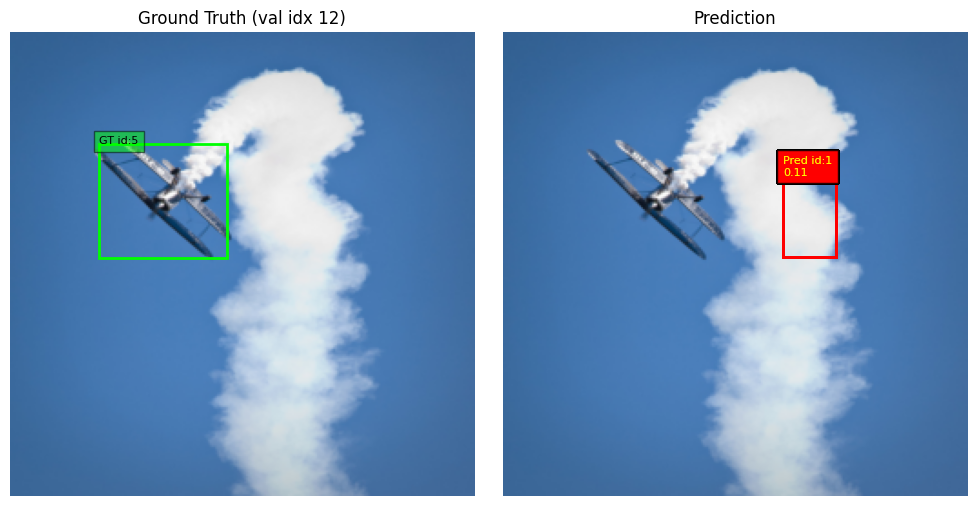

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Chọn 1 ảnh từ val_dataset để visualize
idx = 12  # bạn có thể đổi số khác cho ra ảnh khác
img, target = val_dataset[idx]   # img: [3,H,W], target: {"boxes","labels"}

# Chuẩn bị ảnh numpy để vẽ
img_np = img.permute(1, 2, 0).cpu().numpy()
H, W = img_np.shape[:2]

gt_boxes = target["boxes"]      # [N,4] dạng (cx,cy,w,h) normalized
gt_labels = target["labels"]    # [N]

# Hàm convert bbox (cx,cy,w,h norm) -> (x1,y1,x2,y2) pixel
def cxcywh_to_xyxy_norm(box, W, H):
    cx, cy, w, h = box.tolist()
    x1 = (cx - w/2) * W
    y1 = (cy - h/2) * H
    x2 = (cx + w/2) * W
    y2 = (cy + h/2) * H
    return x1, y1, x2, y2

# ---- CHẠY MODEL ĐỂ LẤY PREDICTION ----
state = torch.load("detr_dinov3_coco_mini.pth", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
with torch.no_grad():
    x = img.unsqueeze(0).to(device)  # [1,3,H,W]
    outputs = model(x)

logits = outputs["pred_logits"][0]      # [Q,num_classes]
boxes_pred = outputs["pred_boxes"][0]   # [Q,4] (cx,cy,w,h norm)

probs = logits.softmax(-1)          # [Q,91]
probs_fg = probs[:, 1:]             # [Q,90]  (bỏ class 0)

scores, labels_fg = probs_fg.max(-1)   # labels_fg ∈ [0..89]
labels_pred = labels_fg + 1            # chuyển về [1..90] giống GT

# Chọn những box có score đủ cao
score_thresh = 0.01
keep = scores > score_thresh

print("Max score:", float(scores.max()))
top_to_print = min(10, scores.numel())
print("Top scores:", scores.topk(top_to_print).values.cpu().tolist())
topk = min(10, scores.numel())         # muốn nhiều hơn thì đổi 10 -> 20
top_scores, top_idx = scores.topk(topk)


boxes_pred  = boxes_pred[keep].cpu()
scores_pred = scores[keep].cpu()
labels_pred = labels_pred[keep].cpu()

# ---- VẼ HÌNH: 1 hàng 2 cột (GT / PRED) ----
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# ========== 1) Ground Truth ==========
ax = axes[0]
ax.imshow(img_np)
ax.set_title(f"Ground Truth (val idx {idx})")
ax.axis("off")

for b, lab in zip(gt_boxes, gt_labels):
    x1, y1, x2, y2 = cxcywh_to_xyxy_norm(b, W, H)
    rect = patches.Rectangle(
        (x1, y1), x2-x1, y2-y1,
        linewidth=2,
        edgecolor="lime",    # xanh lá
        facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1,
        f"GT id:{int(lab)}",
        fontsize=8,
        color="black",
        bbox=dict(facecolor="lime", alpha=0.5)
    )

# ========== 2) Prediction ==========
ax = axes[1]
ax.imshow(img_np)
ax.set_title("Prediction")
ax.axis("off")

for b, s, lab in zip(boxes_pred, scores_pred, labels_pred):

    x1, y1, x2, y2 = cxcywh_to_xyxy_norm(b, W, H)
    rect = patches.Rectangle(
        (x1, y1), x2-x1, y2-y1,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1,
        f"Pred id:{int(lab)}\n{float(s):.2f}",
        fontsize=8,
        color="yellow",
        bbox=dict(facecolor="red", alpha=0.6)
    )

plt.tight_layout()
plt.show()
